# Обучение трансформеров для извлечения именованных сущностей в текстах об аллергии

### Цель проекта

Обучить модель на основе архитектуры BERT для извлечения именованных сущностей из сообщений в группе VK, посвящённой сезонной аллергии. Модель должна распознавать:

* Топонимы (места, где происходит пыление)

* Лекарства (препараты, которые используют аллергики)

* Симптомы (жалобы пользователей)

* Аллергены (пыльца каких растений/деревьев вызывает реакцию)

Существующие предобученные модели (например, BERT-NER) не подходят, так как их классы сущностей не соответствуют нашей задаче.

## 1. Исследовательский анализ данных

**Импротируем необходимые библиотеки**

In [13]:
import pandas as pd
import re
from pymystem3 import Mystem
from label_studio_sdk import Client
from label_studio_converter import Converter
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorForTokenClassification, AutoModelForTokenClassification, Trainer, TrainingArguments, AutoConfig, pipeline
import evaluate
import seqeval
import torch
from torch.nn import CrossEntropyLoss
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 
from collections import defaultdict, Counter
import seaborn as sns
from sklearn.metrics import classification_report
from torch.nn import CrossEntropyLoss
from sklearn.cluster import KMeans
from torch.nn.functional import softmax

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100

**Импортируем и ознакомимся с датасетом**

In [10]:
df = pd.read_csv('../dataset_v1.csv', delimiter=';', index_col=0)

In [3]:
print(df.info())
print('-' * 20)
print(df.head(10))
print('-' * 20)
print(df.loc[0])

<class 'pandas.core.frame.DataFrame'>
Index: 4143 entries, 0 to 4142
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4143 non-null   object
dtypes: object(1)
memory usage: 64.7+ KB
None
--------------------
                                                text
0             Утром проснулась с отекшими глазами)))
1  Открывала окна без спандбонда, нормально, ниче...
2  Пока изменений в худшую сторону нет. Каникулы,...
3  Я сегодня еле разодрала глаза и до сих сдуться...
4  Я тоже сегодня опухшая, надутая, глаза дерет, ...
5  А интересно, ловушка завтра совсем нулевая буд...
6  Ребенок сегодня проснулся с отекшими глазами (...
7  Вышла на улицу, Одинцово мо, тяжело дышать на ...
8  Второй день нормально. Сегодня даже легче,чем ...
9  Вчера после прогулки глаза отекли , чесались ....
--------------------
text    Утром проснулась с отекшими глазами)))
Name: 0, dtype: object


**Общий вывод:** 

Датасет полностью подходит для поставленной задачи. Имеющегося количества сообщений достаточно для обучения модели, при этом данные содержат все необходимые типы сущностей в явном виде. Качество исходных текстов позволяет рассчитывать на хороший результат после корректной разметки и предварительной обработки.

## 2. Разметка данных

Возьмем по 100 строк для обучения, валидации и теста. Сразу очистим их от лишних символов

In [18]:
def clear_data(row):
   rus_text = re.sub(r'[^а-яА-ЯёЁ0-9\s.,!?-]', ' ', row)
   clear_text = ' '.join(rus_text.split())
   return clear_text

In [5]:
df_validate = df.iloc[:100].copy()
df_validate['text'] = df['text'].iloc[:100].apply(clear_data)
df_train = df.iloc[101:201].copy()
df_train['text'] = df['text'].iloc[101:201].apply(clear_data)
df_test = df.iloc[202:302].copy()
df_test['text'] = df['text'].iloc[202:302].apply(clear_data)

In [6]:
df_validate.info()
print('-' * 20)
df_train.info()
print('-' * 20)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 101 to 200
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 202 to 301
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    100 non-null    object
dtypes: object(1)
memory usage: 1.6+ KB


Мы получили 3 набора данных, теперь отправим из в Label studio для разметки

In [22]:
LABEL_STUDIO_URL = 'http://localhost:8080'
API_KEY = open("label_studio.token").readline()
ls = Client(url=LABEL_STUDIO_URL, api_key=API_KEY)
ls.check_connection()

{'status': 'UP'}

In [23]:
def create_task(name, data):
    project = ls.start_project(
    title=name,
    label_config='''
    <View>
    <Labels name="label" toName="text">
     <Label value="LOC" background="red"/>
     <Label value="SYMPTOM" background="blue"/>
     <Label value="MEDICATION" background="orange"/>
     <Label value="ALLERGEN" background="green"/>
    </Labels>
    <Text name="text" value="$text"/>
    </View>
     '''
     )
    
    upload_tasks = [{"text": text} for text in data['text']]
    project.import_tasks(upload_tasks)

In [9]:
create_task('Validate', df_validate)
create_task('Train', df_train)
create_task('Test', df_test)

## 3. Обучение модели

После разметки данных нужно их перенести сюда, есть несколько способов это сделать, но я предпочитаю экспорт в формате .conll. Экспорт в таком формате удобен тем, что он уже имеет нужную нам BIO разметку и нет необходимости писать дополнительный код разметки, который разметит хуже, чем этот формат.

Создадим словари с метками

In [3]:
id2label = {
    0: "O",
    1: "B-ALLERGEN",
    2: "I-ALLERGEN",
    3: "B-SYMPTOM",
    4: "I-SYMPTOM",
    5: "B-MEDICATION",
    6: "I-MEDICATION",
    7: "B-LOC",
    8: "I-LOC",
}
label2id = {v: k for k, v in id2label.items()}
label2id

{'O': 0,
 'B-ALLERGEN': 1,
 'I-ALLERGEN': 2,
 'B-SYMPTOM': 3,
 'I-SYMPTOM': 4,
 'B-MEDICATION': 5,
 'I-MEDICATION': 6,
 'B-LOC': 7,
 'I-LOC': 8}

И функция для преобразования conll файла в датасет

In [4]:
def read_conll_file(path):
    sentences = []
    labels = []
    with open(path, encoding="utf-8") as f:
        tokens = []
        tags = []
        for line in f:
            line = line.strip()
            if not line or line.startswith("-DOCSTART-"):
                if tokens:
                    sentences.append(tokens)
                    labels.append([label2id[tag] for tag in tags])
                    tokens = []
                    tags = []
                continue
            splits = line.split()
            if len(splits) == 4:
                token = splits[0]
                tag = splits[3]
                tokens.append(token)
                tags.append(tag)
        if tokens:
            sentences.append(tokens)
            labels.append([label2id[tag] for tag in tags])
    return {"tokens": sentences, "ner_tags": labels}


def load_conll_dataset(train_path, valid_path=None):
    train_data = read_conll_file(train_path)
    datasets = {"train": Dataset.from_dict(train_data)}
    if valid_path:
        valid_data = read_conll_file(valid_path)
        datasets["validation"] = Dataset.from_dict(valid_data)
    return DatasetDict(datasets)

Импортируем наши файлы

In [8]:
raw_datasets = load_conll_dataset('train.conll', 'validate.conll')

In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

In [179]:
raw_datasets['train'][1]

{'tokens': ['Москва',
  ',',
  'состояние',
  'плохое.',
  'Очень',
  'странные',
  'данные',
  '.'],
 'ner_tags': [7, 0, 0, 0, 0, 0, 0, 0]}

Импорт прошел успешно, у нас есть 2 датасета, в каждом текст в веде токенов и соответствующие тексту тэги. Теперь создадим функцию обучения модели

In [5]:
def train_model(data, model_checkpoint, model_output):
    metric = evaluate.load("seqeval")
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    
    def tokenize_and_align_labels(examples):
        tokenized_inputs = tokenizer(
            examples["tokens"], 
            truncation=True, 
            is_split_into_words=True,
            padding=True
        )
        labels = []
        for i, label in enumerate(examples["ner_tags"]):
            word_ids = tokenized_inputs.word_ids(batch_index=i)
            previous_word_idx = None
            label_ids = []
            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)
                elif word_idx != previous_word_idx:
                    label_ids.append(label[word_idx])
                else:
                    label_ids.append(-100)
                previous_word_idx = word_idx
            labels.append(label_ids)
        tokenized_inputs["labels"] = labels
        return tokenized_inputs
    
    tokenized_datasets = data.map(
        tokenize_and_align_labels,
        batched=True,
        remove_columns=data["train"].column_names
    )

    def count_class_instances(dataset):
        all_labels = []
        for batch in dataset:
            labels = batch["labels"]
            valid_labels = [label for label in labels if label != -100]
            all_labels.extend(valid_labels)
        return Counter(all_labels)

    class_counts = count_class_instances(tokenized_datasets["train"])
    print("Class distribution:", class_counts)

    num_labels = len(id2label)
    counts = [class_counts.get(i, 0) for i in range(num_labels)]
    eps = 1e-6
    counts = [count if count > 0 else eps for count in counts]
    class_weights = 1.0 / torch.sqrt(torch.tensor(counts, dtype=torch.float32))
    class_weights = class_weights / class_weights.sum() * num_labels

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class_weights = class_weights.to(device)

    def compute_metrics(eval_preds):
        logits, labels = eval_preds
        predictions = np.argmax(logits, axis=-1)

        true_predictions = [
            [id2label[p] for (p, l) in zip(preds, label) if l != -100]
            for preds, label in zip(predictions, labels)
        ]
        true_labels = [
            [id2label[l] for l in label if l != -100]
            for label in labels
        ]

        filtered_preds = []
        filtered_labels = []
        for preds, lbls in zip(true_predictions, true_labels):
            filtered_preds.append([p for p, l in zip(preds, lbls) if l != 'O'])
            filtered_labels.append([l for l in lbls if l != 'O'])

        if filtered_labels and filtered_labels[0]:
            results = metric.compute(predictions=filtered_preds, references=filtered_labels)
            return {
                "f1": results["overall_f1"],
                "precision": results["overall_precision"],
                "recall": results["overall_recall"],
            }
        return {"f1": 0.0, "precision": 0.0, "recall": 0.0}

    config = AutoConfig.from_pretrained(
        model_checkpoint,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        hidden_dropout_prob=0.3,
        attention_probs_dropout_prob=0.3,
    )

    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint,
        config=config
    ).to(device)

    data_collator = DataCollatorForTokenClassification(tokenizer)

    # Рассчёт warmup_steps на основе размера датасета
    per_device_train_batch_size = 16
    num_train_epochs = 20
    num_training_steps = (len(tokenized_datasets["train"]) // per_device_train_batch_size) * num_train_epochs
    warmup_steps = int(0.1 * num_training_steps)

    args = TrainingArguments(
        model_output,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=1e-5,
        warmup_steps=warmup_steps,
        num_train_epochs=num_train_epochs,
        weight_decay=0.01,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=16,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=3,
        fp16=True,
        max_grad_norm=1.0,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["validation"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    def compute_loss(model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    trainer.compute_loss = compute_loss
    
    trainer.train()

    metrics = trainer.state.log_history
    epochs = []
    train_loss = []
    eval_loss = []
    f1 = []
    precision = []
    recall = []
    
    for record in metrics:
        if 'epoch' in record:
            epochs.append(record['epoch'])
            train_loss.append(record.get('loss', None))
            eval_loss.append(record.get('eval_loss', None))
            f1.append(record.get('eval_f1', None))
            precision.append(record.get('eval_precision', None))
            recall.append(record.get('eval_recall', None))
    
    def clean_metric(epochs, metric):
        cleaned_epochs = []
        cleaned_metric = []
        for e, m in zip(epochs, metric):
            if m is not None:
                cleaned_epochs.append(e)
                cleaned_metric.append(m)
        return cleaned_epochs, cleaned_metric
    
    def plot_metric(epochs, metric_values, title, ylabel):
        if len(metric_values) == 0:
            print(f"No data to plot for {title}")
            return
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, metric_values, linestyle='-')
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    epochs_tl, train_loss_clean = clean_metric(epochs, train_loss)
    epochs_el, eval_loss_clean = clean_metric(epochs, eval_loss)
    epochs_f1, f1_clean = clean_metric(epochs, f1)
    epochs_p, precision_clean = clean_metric(epochs, precision)
    epochs_r, recall_clean = clean_metric(epochs, recall)
    
    plot_metric(epochs_tl, train_loss_clean, "Training Loss per Epoch", "Train Loss")
    plot_metric(epochs_el, eval_loss_clean, "Validation Loss per Epoch", "Val Loss")
    plot_metric(epochs_f1, f1_clean, "F1 Score per Epoch", "F1")
    plot_metric(epochs_p, precision_clean, "Precision per Epoch", "Precision")
    plot_metric(epochs_r, recall_clean, "Recall per Epoch", "Recall")

Подготовим модель к обучению

In [17]:
model_checkpoint = "DeepPavlov/rubert-base-cased" 

Запустим обучение

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3570.71 examples/s]


Class distribution: Counter({0: 1524, 3: 64, 1: 46, 7: 36, 4: 33, 5: 17, 8: 10, 6: 5, 2: 4})


Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Chris\AppData\Local\Temp\ipykernel_2680\4220689642.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,2.287000,2.208499,0.100257,0.098985,0.101562
2,1.994900,1.991957,0.000000,0.000000,0.000000
3,1.691400,2.018818,0.000000,0.000000,0.000000
4,1.616200,1.972722,0.000000,0.000000,0.000000
5,1.623000,1.870977,0.000000,0.000000,0.000000
6,1.523700,1.784920,0.010101,0.166667,0.005208
7,1.423300,1.729266,0.052632,0.323529,0.028646
8,1.346400,1.703695,0.072289,0.483871,0.039062
9,1.377600,1.661890,0.124444,0.424242,0.072917
10,1.381100,1.614189,0.175153,0.401869,0.111979


C:\Users\Chris\OneDrive\Рабочий стол\alerg_prpject\jupyter_projects\venv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chris\OneDrive\Рабочий стол\alerg_prpject\jupyter_projects\venv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Chris\OneDrive\Рабочий стол\alerg_prpject\jupyter_projects\venv\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

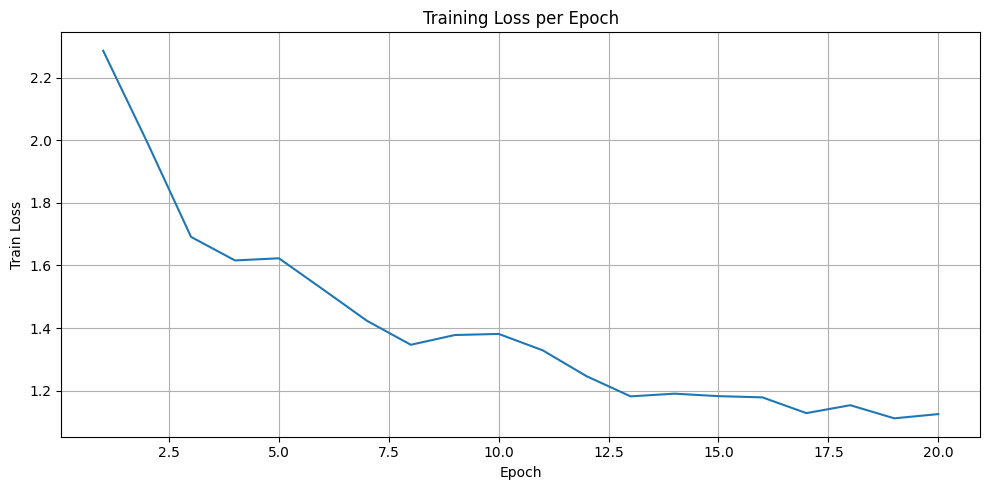

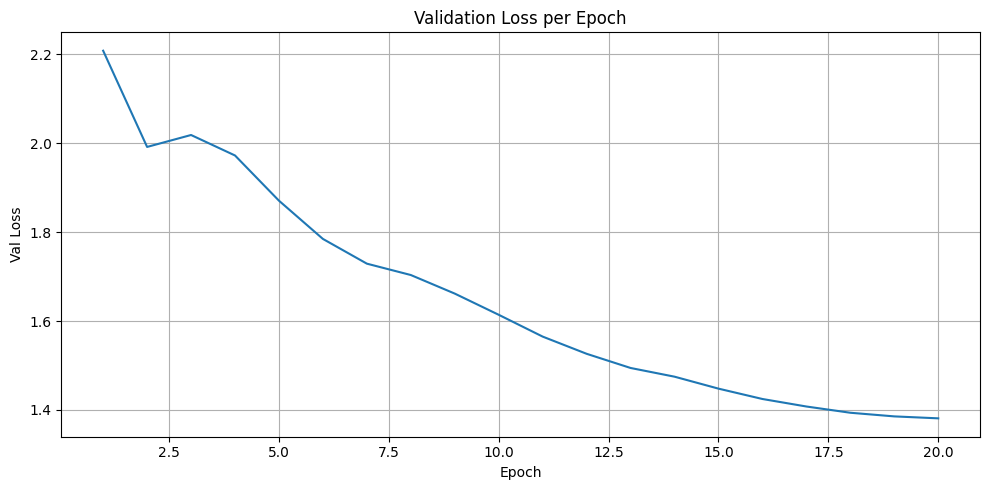

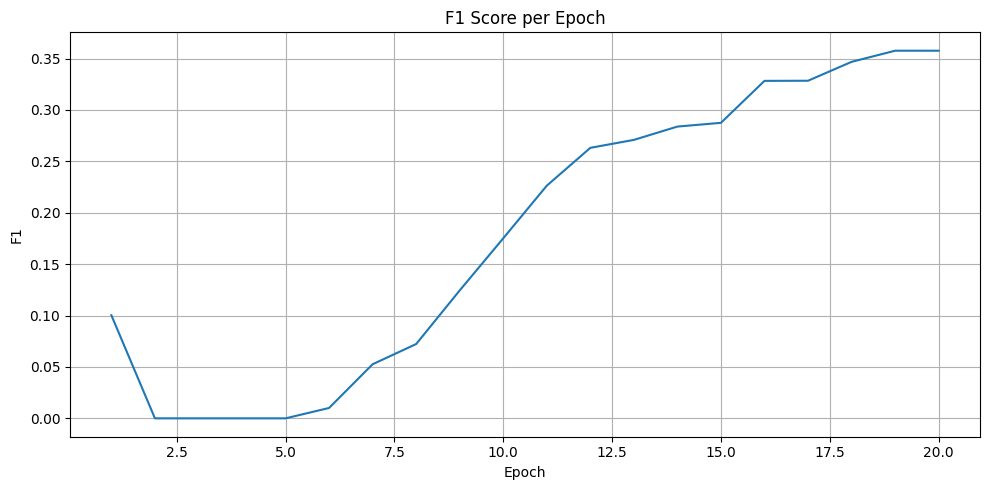

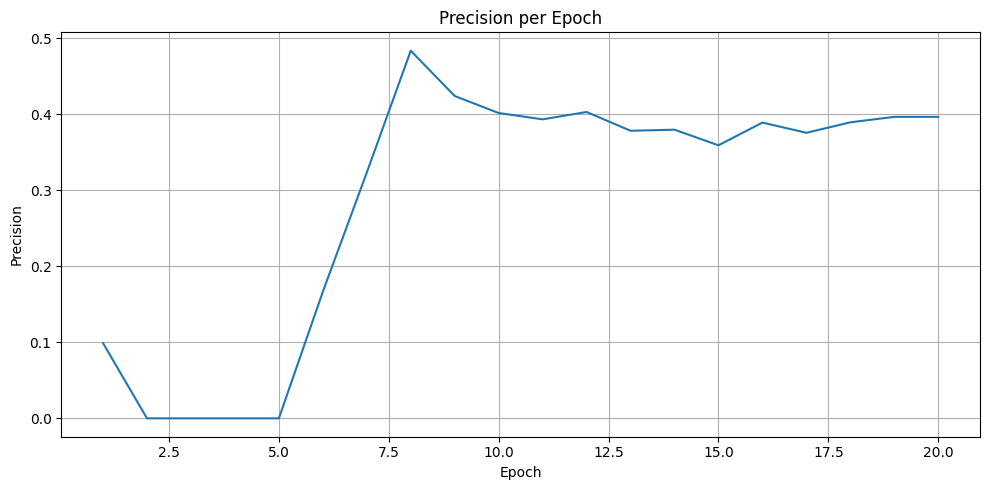

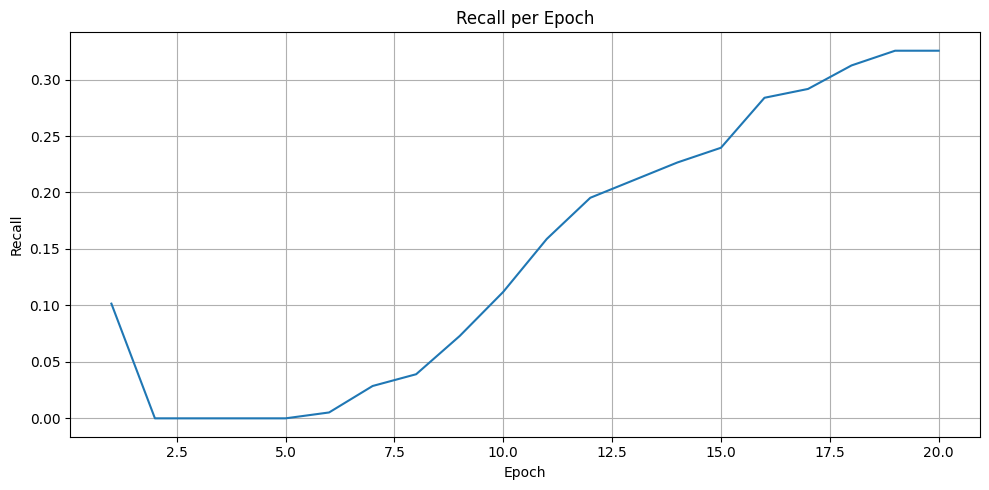

In [21]:
train_model(raw_datasets, model_checkpoint, 'alerg_model')

| Эпоха | Анализ вывода                                                                                                                                                                                                                                                                                                                       |
| ----- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1–5   | Потери на обучении и валидации плавно снижаются с 2.29 до \~1.62 и 2.21 до 1.87 соответственно. F1 практически равен 0 (кроме 1-й эпохи \~0.1), точность и полнота нулевые. Модель только начинает обучаться, практически не распознаёт сущности — "модель учится, но пока слабо распознаёт".         |
| 6–8   | F1 резко падает почти до нуля, но точность высока (16.6–48.4%), при этом полнота очень низкая (0.5–3.9%). Потери продолжают снижаться, но не так активно. Это классический этап, когда модель "выбирает" сущности изредка, сильно пропуская. Адаптация к сложным классам и избирательность.  |
| 9     | В 9-й эпохе F1 внезапно прыгает до 0.124, полнота удваивается до 7.3%, а точность остаётся высокой (42%). Потери уменьшаются. Это начало стадии, когда модель становится увереннее в извлечении сущностей, лучше разделяет классы и фон.                                                                      |
| 10–13 | F1 растёт стабильно до 0.27, точность держится на уровне \~37–40%, полнота поднимается с 11% до 21%. Потери обучающей и валидационной выборок снижаются, что говорит о качественном обучении. Баланс точности и полноты начинает улучшаться.                     |
| 14–20 | В этом диапазоне F1 поднимается до \~0.36, точность стабилизируется около 36–40%, полнота растёт до 32%. Потери валидации продолжают снижаться и стабилизируются около 1.38–1.39, обучение замедляется, модель достигает плато. |


In [6]:
def get_text_embeddings(texts, model, tokenizer, device):
    model.eval()
    encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    with torch.no_grad():
        outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = outputs.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = (last_hidden_state * mask).sum(1)
    counts = mask.sum(1)
    embeddings = (summed / counts).cpu().numpy()
    return embeddings

def analyze_text_batch(texts, model, tokenizer):
    device = next(model.parameters()).device
    encodings = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    logits = outputs.logits
    probs = torch.nn.functional.softmax(logits, dim=-1)
    max_probs, _ = probs.max(dim=-1)

    # Маска: обнуляем паддинги
    max_probs = max_probs * attention_mask

    # Средняя уверенность по токенам (исключая паддинги)
    token_counts = attention_mask.sum(dim=1)
    mean_conf = (max_probs.sum(dim=1) / token_counts).cpu()

    return mean_conf.numpy()
    
def is_useful(text, min_words=3, min_chars=15):
    if not isinstance(text, str):
        return False
    text = text.strip()
    if len(text) < min_chars:
        return False
    if len(text.split()) < min_words:
        return False
    if re.fullmatch(r"[а-яА-Я0-9\s\.\,\?\!\-]+", text) is None:
        return False
    return True
    
def find_problematic_examples(
    data,
    model,
    tokenizer,
    top_n=100,
    uncertainty_threshold=None,
    batch_size=16,
    drop_duplicates=True,
    filter_useful=True,
    diversity_clusters=10,
    device=None
):
    model.eval()
    device = device or next(model.parameters()).device

    original_data = data.copy()

    if drop_duplicates:
        data = data.drop_duplicates(subset='text')

    if filter_useful:
        data = data[data['text'].apply(is_useful)]

    data = data.reset_index(drop=True)
    all_confidences = []

    for i in tqdm(range(0, len(data), batch_size)):
        batch_texts = data['text'].iloc[i:i + batch_size].tolist()
        confidences = analyze_text_batch(batch_texts, model, tokenizer)
        all_confidences.extend(confidences)

    result_df = data.copy()
    result_df['confidence'] = all_confidences
    result_df['uncertainty'] = 1 - result_df['confidence']

    if uncertainty_threshold is not None:
        result_df = result_df[result_df['uncertainty'] > uncertainty_threshold]

    if len(result_df) > diversity_clusters:
        embeddings = get_text_embeddings(result_df['text'].tolist(), model, tokenizer, device)
        kmeans = KMeans(n_clusters=diversity_clusters, random_state=42)
        clusters = kmeans.fit_predict(embeddings)
        result_df['cluster'] = clusters

        diversified = []
        for cluster_id in range(diversity_clusters):
            cluster_subset = result_df[result_df['cluster'] == cluster_id]
            cluster_top = cluster_subset.sort_values('uncertainty', ascending=False).head(max(1, top_n // diversity_clusters))
            diversified.append(cluster_top)
        result_df = pd.concat(diversified)

    result_df = result_df.sort_values('uncertainty', ascending=False).head(top_n)

    # --- Удаляем выбранные тексты из исходного датасета ---
    selected_texts = set(result_df['text'].tolist())
    remaining_data = original_data[~original_data['text'].isin(selected_texts)].reset_index(drop=True)

    return result_df.reset_index(drop=True), remaining_data.reset_index(drop=True)


Напишем функцию для загрузки обученной модели

In [7]:
def load_model(model_path):
    print("Загрузка модели...")
    model = AutoModelForTokenClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    config = AutoConfig.from_pretrained(model_path)
    
    # Получаем информацию о классах
    id2label = config.id2label
    label2id = config.label2id
    entity_types = list(set(label.split('-')[1] for label in id2label.values() if '-' in label))
    
    print(f"Загружена модель: {config.model_type}")
    print("Типы сущностей:", entity_types)
    return model, tokenizer

Теперь получим датасет с неуверенными примерами

In [39]:
# Получаем проблемные примеры
model, tokenizer = load_model("alerg_model/checkpoint-140")
data_search = df[303:]
problematic_df, remaining_data = find_problematic_examples(data_search, model, tokenizer, top_n=100)

# Просмотр результатов
print(f"Найдено {len(problematic_df)} проблемных примеров")
problematic_df.head()

Загрузка модели...
Загружена модель: bert
Типы сущностей: ['ALLERGEN', 'LOC', 'SYMPTOM', 'MEDICATION']


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [02:09<00:00,  1.16s/it]


Найдено 100 проблемных примеров


,text,confidence,uncertainty,cluster
0,Калуга. Нос реагирует. Злаки,0.212311,0.787689,7
1,нос сильно заложен,0.224169,0.775831,3
2,Пульмикорт и бередуал в ингаляциях,0.234003,0.765997,4
3,"Новосибирск, зуд в полости носа. без АГ",0.234340,0.765660,4
4,"Тула, ночью бронхоспазм, утром легкий насморк,...",0.235664,0.764336,4


Перенесем примеры в Label studio и разметим

In [40]:
create_task('train2', problematic_df)

Дообучим модель на новом датасете

In [41]:
train2 = load_conll_dataset('train2.conll', 'validate.conll')
train2

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3225.05 examples/s]


Class distribution: Counter({0: 789, 3: 96, 7: 80, 4: 77, 1: 40, 5: 30, 8: 26, 6: 4, 2: 3})


C:\Users\Chris\AppData\Local\Temp\ipykernel_2680\4220689642.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,1.523600,1.169966,0.366237,0.406349,0.333333
2,1.511200,1.136267,0.369186,0.417763,0.330729
3,1.447500,1.072379,0.413699,0.436416,0.393229
4,1.369500,1.019730,0.424161,0.437673,0.411458
5,1.246600,0.973727,0.459103,0.465241,0.453125
6,1.239500,0.930800,0.496104,0.494819,0.497396
7,1.233400,0.890206,0.507079,0.501272,0.513021
8,1.089700,0.858976,0.524590,0.508557,0.541667
9,1.106300,0.833550,0.527112,0.511002,0.544271
10,1.072300,0.813443,0.533502,0.518428,0.549479


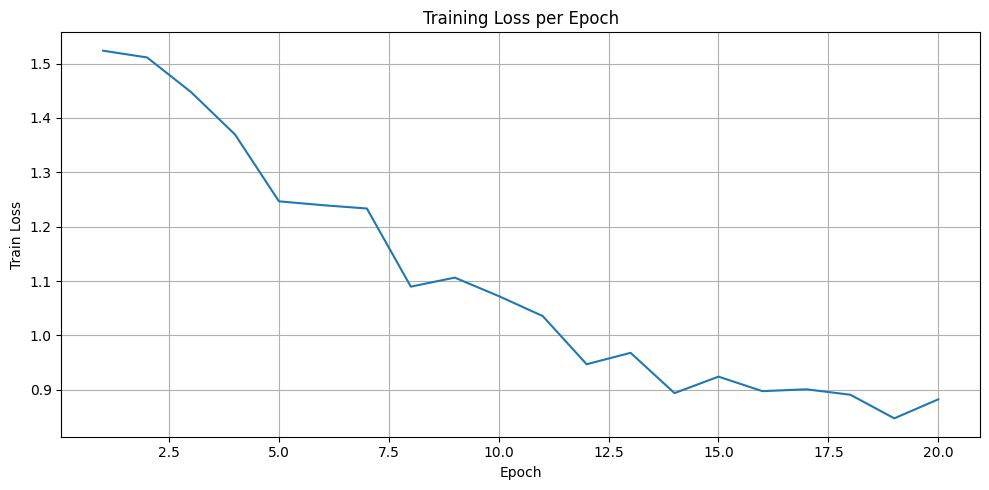

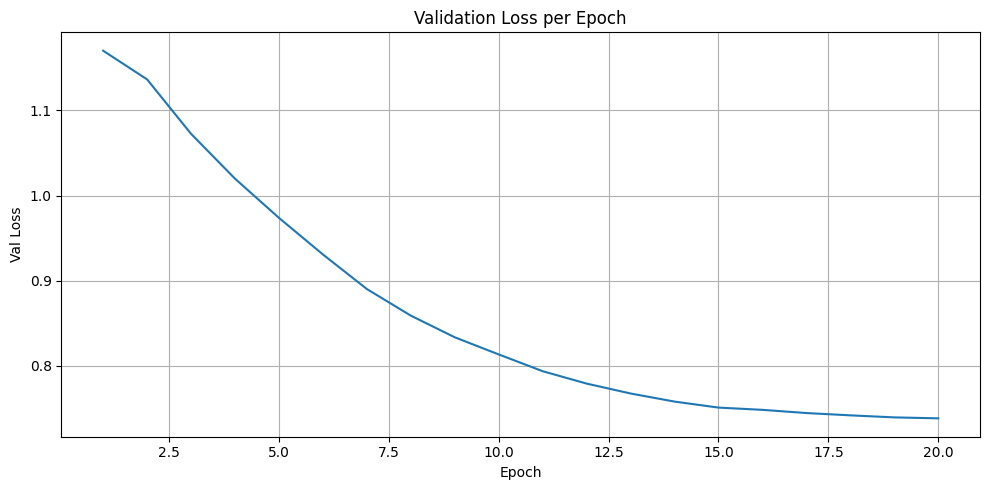

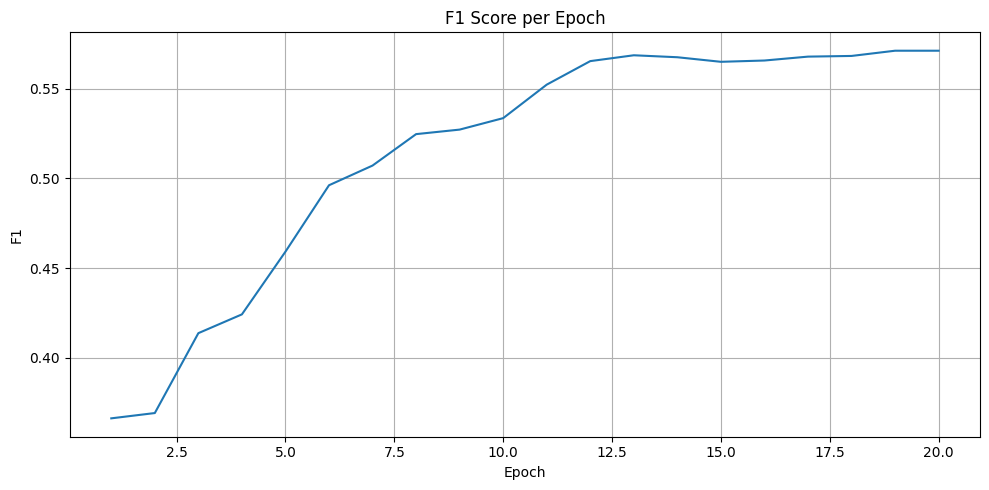

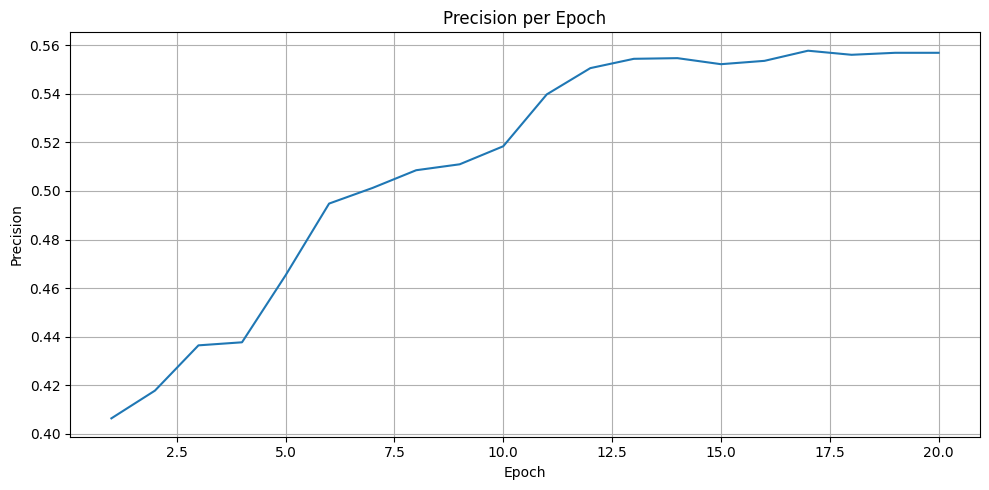

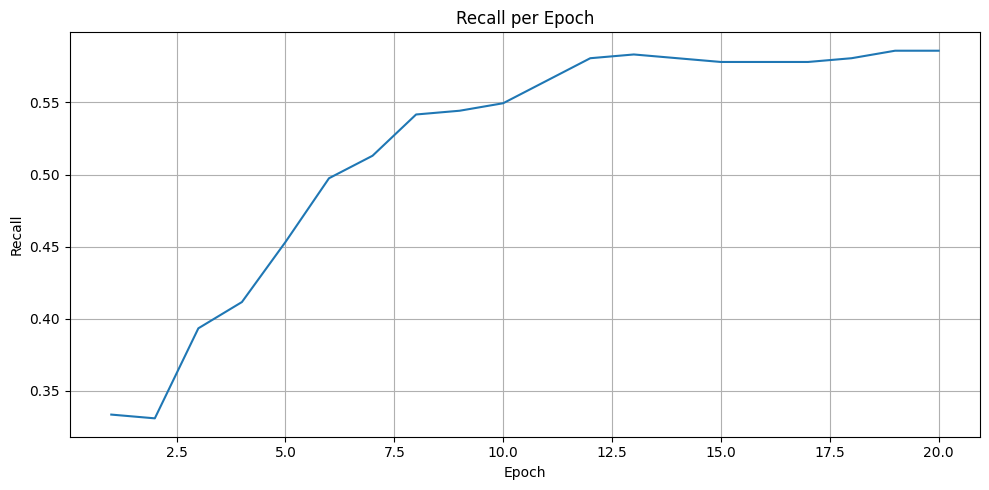

In [43]:
model_checkpoint = "alerg_model/checkpoint-140"
train_model(train2, model_checkpoint, 'second_model')

| Эпоха | Вывод                                                                                                                                                                                          |
| ----- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1–5   | Модель стартует с достаточно высоким уровнем качества (F1 \~0.37–0.46), с хорошим балансом точности и полноты. Потери снижаются, модель быстро адаптируется и уверенно выделяет сущности.      |
| 6–8   | Плавный рост F1 (0.49–0.52), точность и полнота сбалансированы (\~50%), валидационные потери продолжают снижаться. Модель улучшает качество извлечения сущностей и становится более уверенной. |
| 9–13  | Стабильный рост F1 до \~0.57, точность 51–55%, полнота 54–58%, снижение валидационных потерь — модель достигла высокого качества и баланса между точностью и полнотой.                         |
| 14–20 | Метрики стабилизируются, F1 около 0.56–0.57, точность и полнота 55–59%, валидационные потери почти не меняются. Модель достигла оптимума, предсказания стали устойчивыми и сбалансированными.  |


Повторим запрос неуверенных примеров

In [44]:
# Получаем проблемные примеры
load_model("second_model/checkpoint-140")

problematic_df, remaining_data = find_problematic_examples(remaining_data, model, tokenizer, top_n=100)

# Просмотр результатов
print(f"Найдено {len(problematic_df)} проблемных примеров")
problematic_df.head()

Загрузка модели...
Загружена модель: bert
Типы сущностей: ['ALLERGEN', 'LOC', 'SYMPTOM', 'MEDICATION']


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [01:56<00:00,  1.11s/it]


Найдено 100 проблемных примеров


,text,confidence,uncertainty,cluster
0,"МО, Запад. Реагируют глаза",0.263385,0.736615,4
1,"Тула, кашель и покраснение глаз, немного садни...",0.264835,0.735165,4
2,"Тула, чихание и кашель, зуд в носу, пощипывает...",0.265543,0.734457,4
3,"Питер, самочувствие отличное, на базе кларитин...",0.268455,0.731545,4
4,"Уфа\nу ребенка мокротный кашель, ринорея",0.274237,0.725763,4


In [45]:
create_task('train3', problematic_df)

In [46]:
train3 = load_conll_dataset('train3.conll', 'validate.conll')
train3

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3345.38 examples/s]


Class distribution: Counter({0: 767, 3: 100, 7: 88, 4: 65, 5: 37, 8: 34, 1: 25, 6: 7})


C:\Users\Chris\AppData\Local\Temp\ipykernel_2680\4220689642.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,1.033600,1.210736,0.571429,0.550725,0.593750
2,1.010300,1.213869,0.571075,0.543529,0.601562
3,0.955300,1.297248,0.563659,0.536471,0.593750
4,0.873000,1.370981,0.600751,0.578313,0.625000
5,0.849500,1.452287,0.606684,0.598985,0.614583
6,0.825700,1.456256,0.581673,0.593496,0.570312
7,0.785200,1.512321,0.569501,0.591036,0.549479
8,0.725100,1.598258,0.582781,0.592992,0.572917
9,0.727300,1.587731,0.589309,0.590078,0.588542
10,0.710400,1.648470,0.595020,0.598945,0.591146


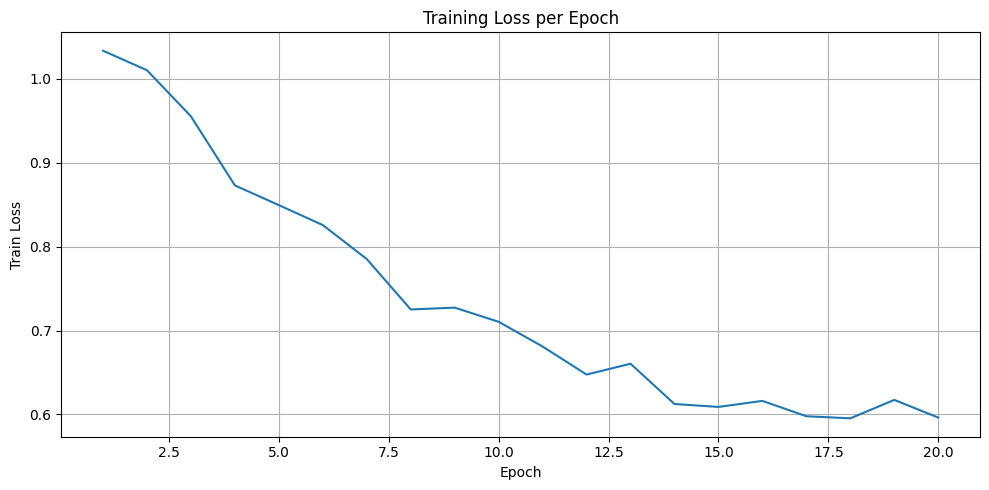

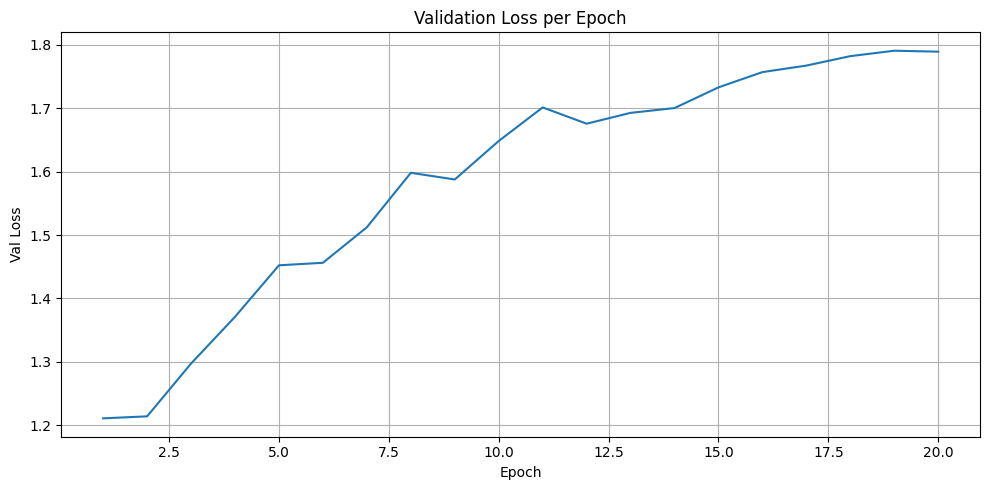

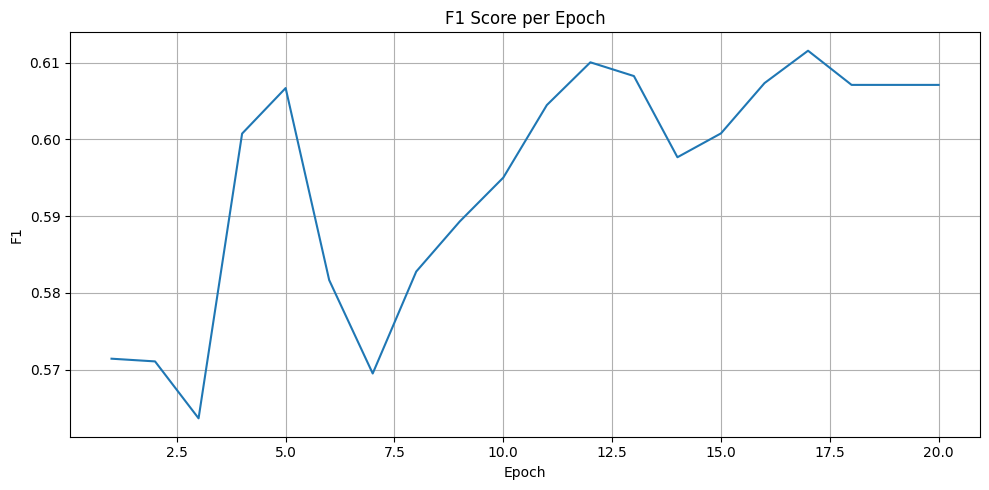

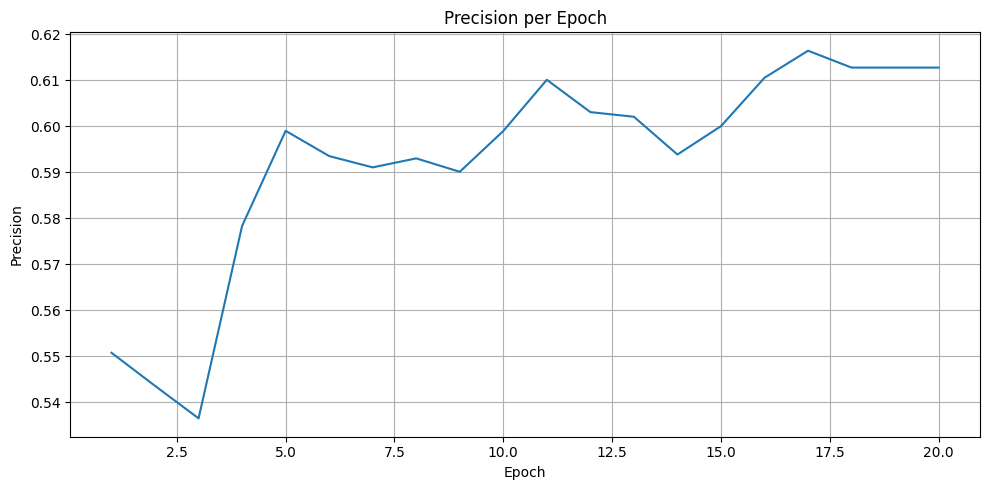

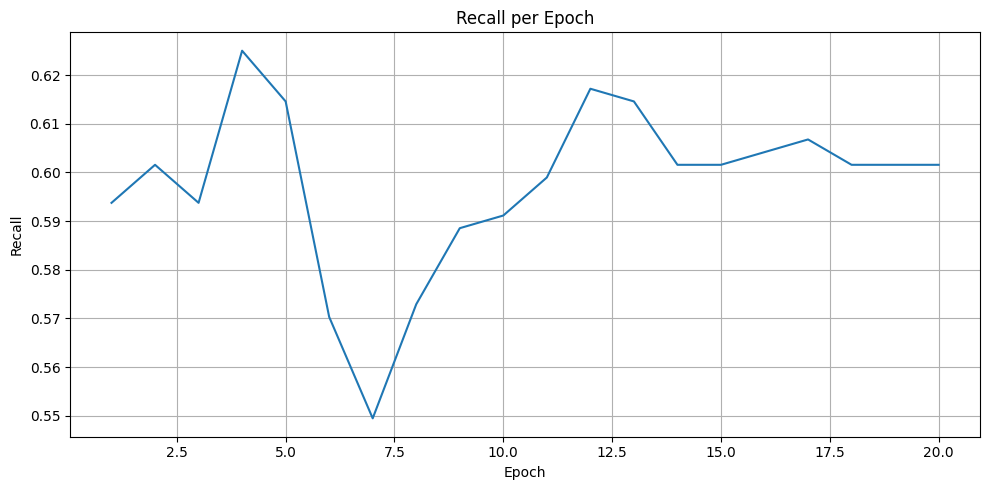

In [47]:
model_checkpoint = "second_model/checkpoint-140"
train_model(train3, model_checkpoint, 'third_model')

| Эпоха | Вывод                                                                                                                                                                                                                             |
| ----- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1–3   | Модель стартует с очень высоким уровнем F1 (\~0.57), но потери растут, особенно на валидации, что может свидетельствовать о начале переобучения.      |
| 4–5   | Краткосрочный рост F1 до 0.60+, несмотря на рост валидационных потерь. Модель делает более уверенные предсказания (precision \~0.59), но это уже начало фазы, где переобучение влияет на обобщающую способность.                  |
| 6–10  | Метрики колеблются (F1 \~0.57–0.59), валидационные потери продолжают расти, точность и полнота сбалансированы. Модель сохраняет устойчивость, но качество начинает немного деградировать.                                         |
| 11–13 | Последний пик качества: F1 до 0.61, модель достигает локального максимума баланса между precision и recall. Несмотря на растущие потери, предсказания устойчивы, точность выше 60%.                                               |
| 14–20 | Метрики стабилизируются на уровне F1 \~0.60–0.61, точность и полнота сбалансированы (60–61%), но валидационные потери продолжают медленно расти. Модель находится в фазе плато — предсказания стабильны, но улучшений больше нет. |


In [48]:
# Получаем проблемные примеры
load_model("third_model/checkpoint-140")

problematic_df, remaining_data = find_problematic_examples(remaining_data, model, tokenizer, top_n=100)

# Просмотр результатов
print(f"Найдено {len(problematic_df)} проблемных примеров")
problematic_df.head()

Загрузка модели...
Загружена модель: bert
Типы сущностей: ['ALLERGEN', 'LOC', 'SYMPTOM', 'MEDICATION']


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [01:46<00:00,  1.08s/it]


Найдено 100 проблемных примеров


,text,confidence,uncertainty,cluster
0,"Рязанская область. Насморк, иногда мокрый каше...",0.285845,0.714155,5
1,"Брянск . Кожный зуд, глаза и горло ощущают дис...",0.287557,0.712443,5
2,"Самочувствие отвратительное, глазам хуже всего",0.291553,0.708447,5
3,"Спб, Петергоф. С утра сильнейший зуд глаз",0.294816,0.705184,1
4,Воскресенск. Аллергия на злаки. Немного чешутс...,0.295968,0.704032,9


In [49]:
create_task('train4', problematic_df)

In [50]:
train4 = load_conll_dataset('train4.conll', 'validate.conll')
train4

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3499.16 examples/s]


Class distribution: Counter({0: 924, 3: 103, 7: 77, 4: 63, 5: 47, 8: 41, 1: 20, 6: 4, 2: 1})


C:\Users\Chris\AppData\Local\Temp\ipykernel_2680\4220689642.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.725200,0.661946,0.619236,0.626667,0.611979
2,0.730500,0.652854,0.639069,0.634961,0.643229
3,0.679800,0.647775,0.639386,0.628141,0.651042
4,0.707100,0.640014,0.658196,0.642680,0.674479
5,0.582100,0.631206,0.649746,0.633663,0.666667
6,0.530200,0.624998,0.663252,0.652393,0.674479
7,0.554000,0.618160,0.674359,0.664141,0.684896
8,0.525400,0.625689,0.659898,0.643564,0.677083
9,0.514000,0.623026,0.670918,0.657500,0.684896
10,0.505200,0.618915,0.682927,0.673418,0.692708


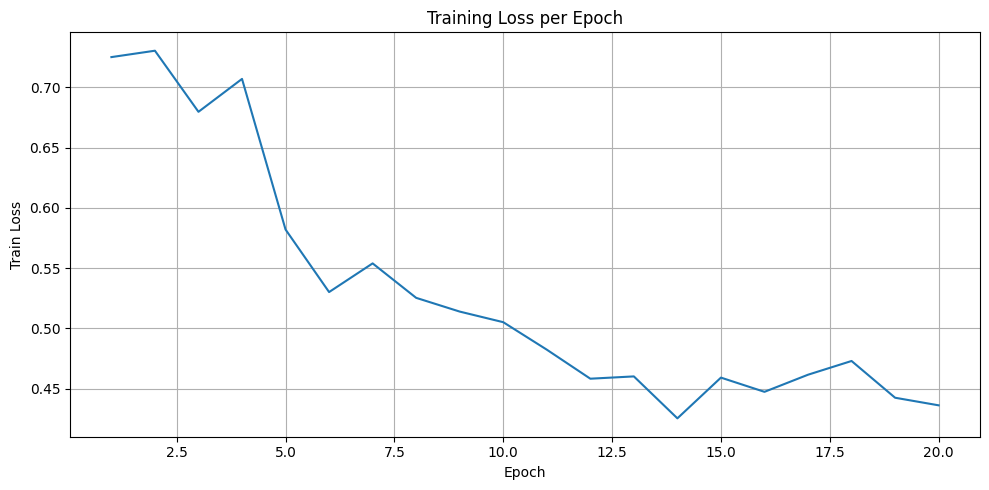

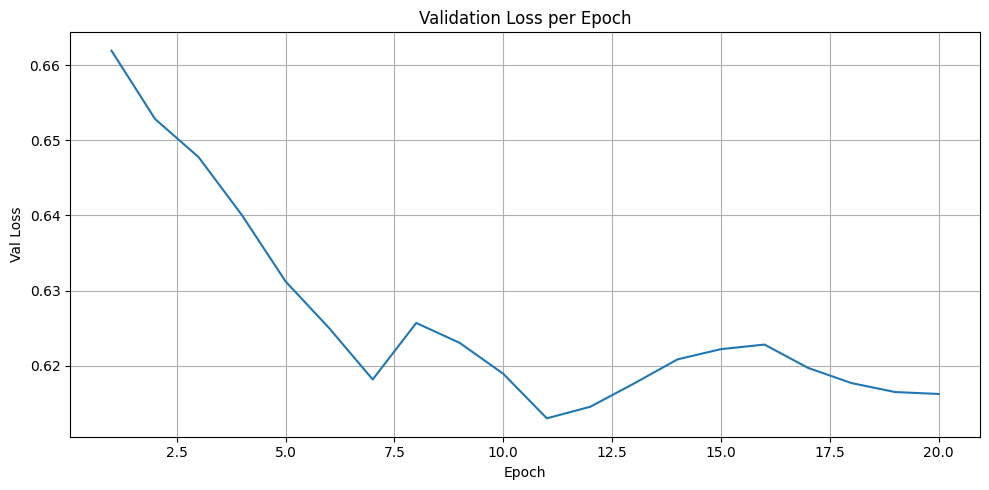

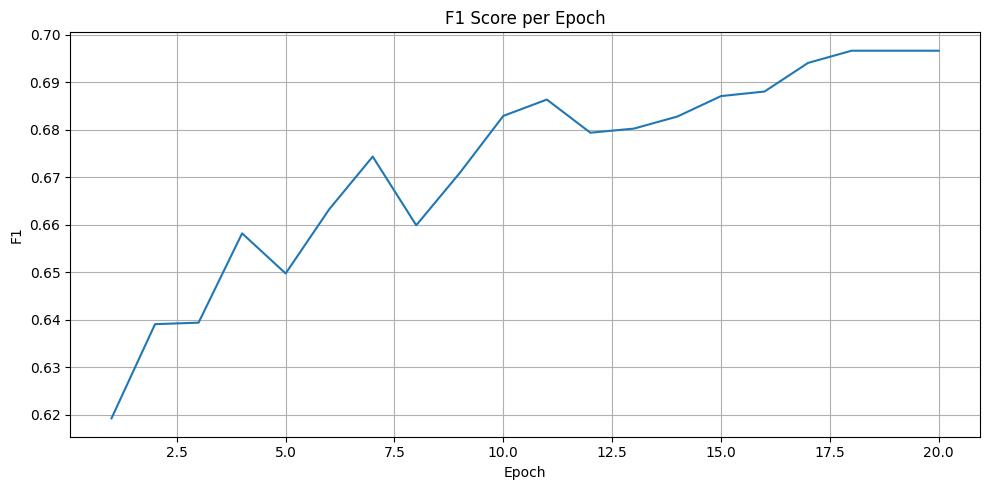

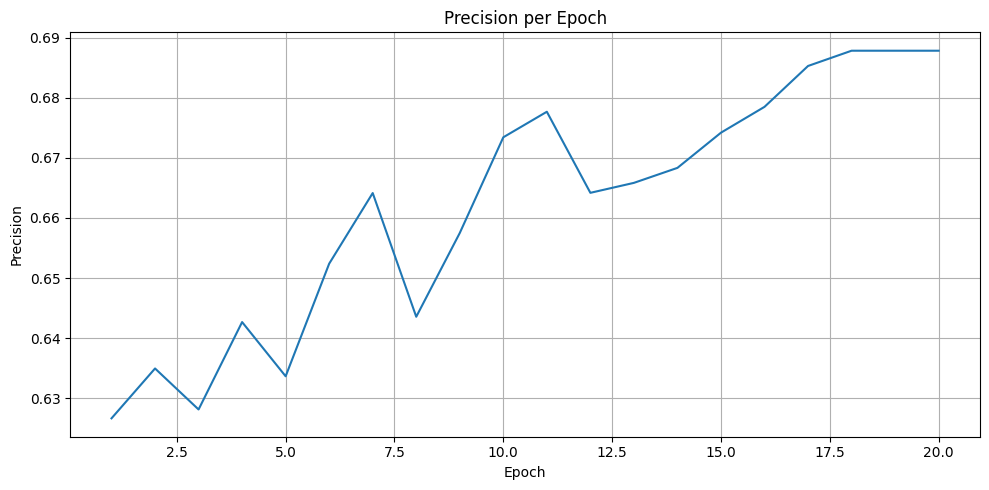

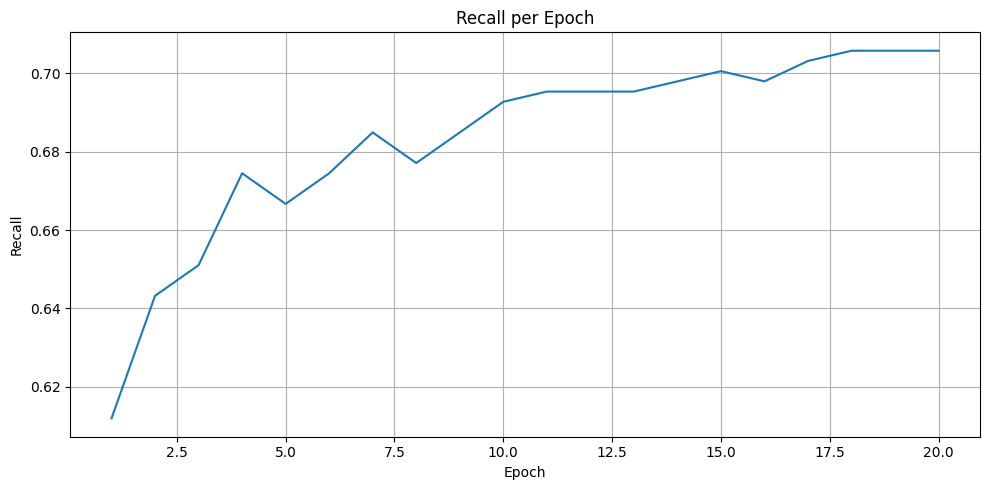

In [52]:
model_checkpoint = "third_model/checkpoint-140"
train_model(train4, model_checkpoint, 'fourth_model')

| Эпоха | Вывод                                                                                                                                                                                                                               |
| ----- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1–3   | Потери уменьшаются стабильно, а точность и полнота сбалансированы — признаки хорошо подготовленной модели или удачного fine-tuning. |
| 4–7   | Уверенный рост F1 до 0.67, точность и полнота синхронно улучшаются (до 66–68%). Валидационные потери плавно падают — модель активно учится, расширяя охват извлекаемых сущностей и снижая ложно-положительные предсказания.         |
| 8–11  | Период выхода на плато. Метрики F1 стабилизируются на уровне 0.68–0.69, точность и полнота выравниваются (67–69%), потери минимальны (\~0.61). Модель достигает зрелого состояния уверенного и сбалансированного извлечения.        |
| 12–16 | Стабильность и незначительный рост: F1 \~0.68–0.69, точность \~66–68%, полнота \~69–70%. Валидационные потери минимальны и почти не меняются. Модель демонстрирует надежные предсказания без переобучения.                          |
| 17–20 | Финальный пик качества — F1 \~0.697, точность 68.7%, полнота 70.5%. Потери \~0.616. Модель устойчиво достигает максимальной производительности, что делает её отличным кандидатом для тестирования в проде.     |


In [53]:
# Получаем проблемные примеры
load_model("fourth_model/checkpoint-140")

problematic_df, remaining_data = find_problematic_examples(remaining_data, model, tokenizer, top_n=100)

# Просмотр результатов
print(f"Найдено {len(problematic_df)} проблемных примеров")
problematic_df.head()

Загрузка модели...
Загружена модель: bert
Типы сущностей: ['ALLERGEN', 'LOC', 'SYMPTOM', 'MEDICATION']


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [01:42<00:00,  1.10s/it]


Найдено 100 проблемных примеров


,text,confidence,uncertainty,cluster
0,"Тула. Чешется горло, течет из носа, съела всег...",0.312005,0.687995,2
1,"Домодедово - глаза фигово , нос дышит пока",0.315548,0.684452,2
2,"Калуга. Ребенок после прогулки раздирал глаза,...",0.316910,0.683090,2
3,"Москва СЗАО, сын нос бесконечно заложена, назо...",0.318298,0.681702,2
4,Москва юзао глаза и дыхание затруднено,0.319584,0.680416,2


In [54]:
create_task('train5', problematic_df)

In [55]:
train5 = load_conll_dataset('train5.conll', 'validate.conll')
train5

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3388.79 examples/s]


Class distribution: Counter({0: 924, 3: 103, 7: 77, 4: 63, 5: 47, 8: 41, 1: 20, 6: 4, 2: 1})


C:\Users\Chris\AppData\Local\Temp\ipykernel_2680\4220689642.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.331700,0.622485,0.691808,0.690909,0.692708
2,0.330200,0.625210,0.713359,0.710594,0.716146
3,0.298400,0.638915,0.700000,0.689394,0.710938
4,0.329200,0.642744,0.720207,0.716495,0.723958
5,0.253000,0.647535,0.714472,0.715405,0.713542
6,0.223200,0.663682,0.703896,0.702073,0.705729
7,0.254000,0.663084,0.713359,0.710594,0.716146
8,0.226400,0.654743,0.712435,0.708763,0.716146
9,0.232000,0.652819,0.716146,0.716146,0.716146
10,0.255200,0.655723,0.723238,0.725131,0.721354


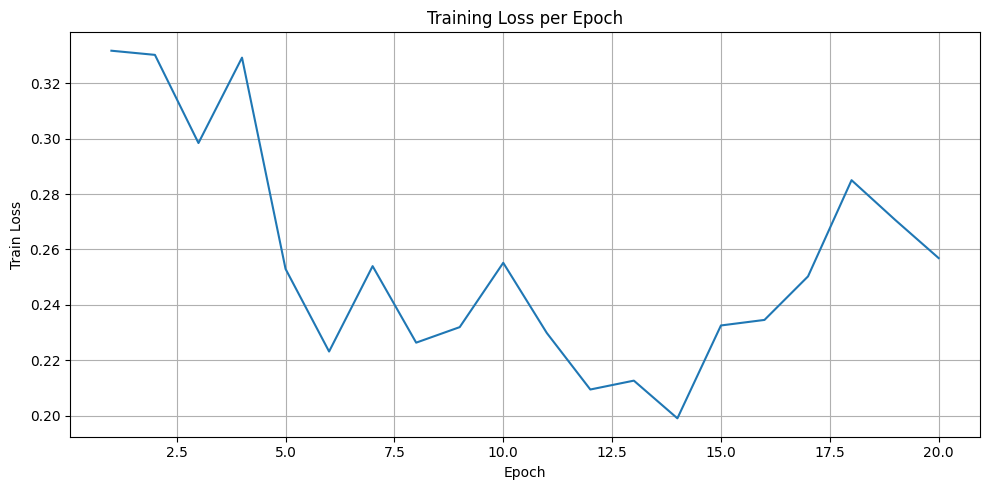

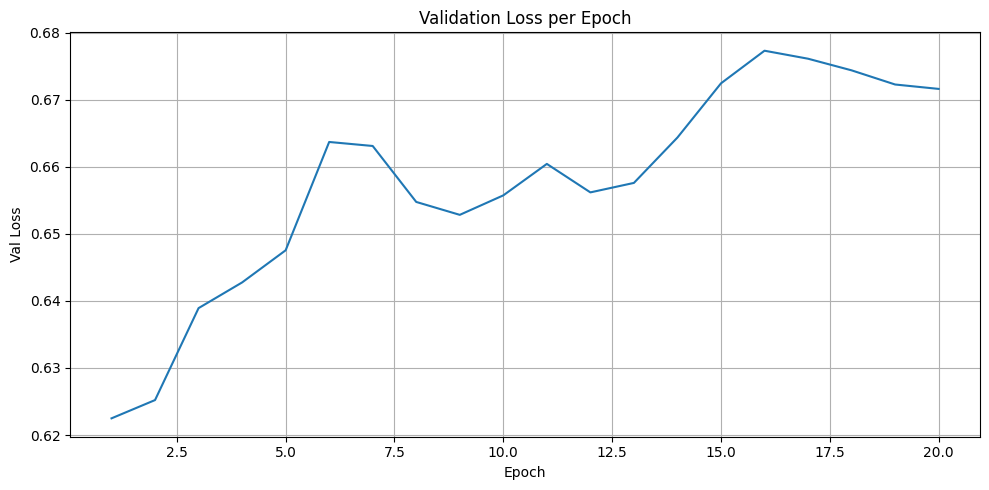

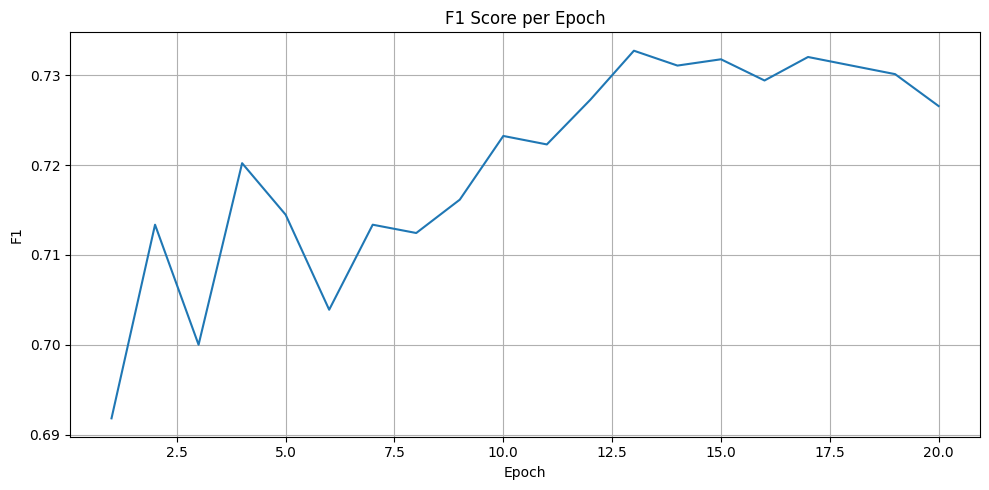

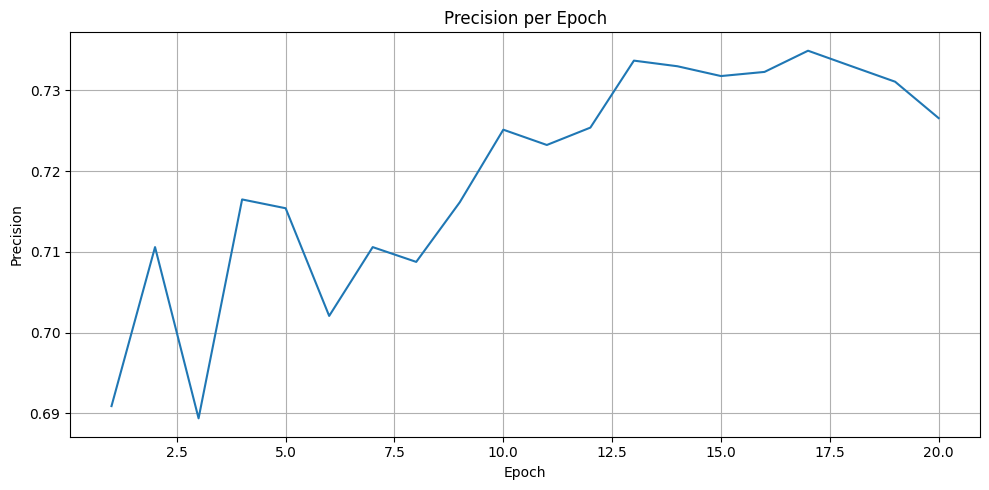

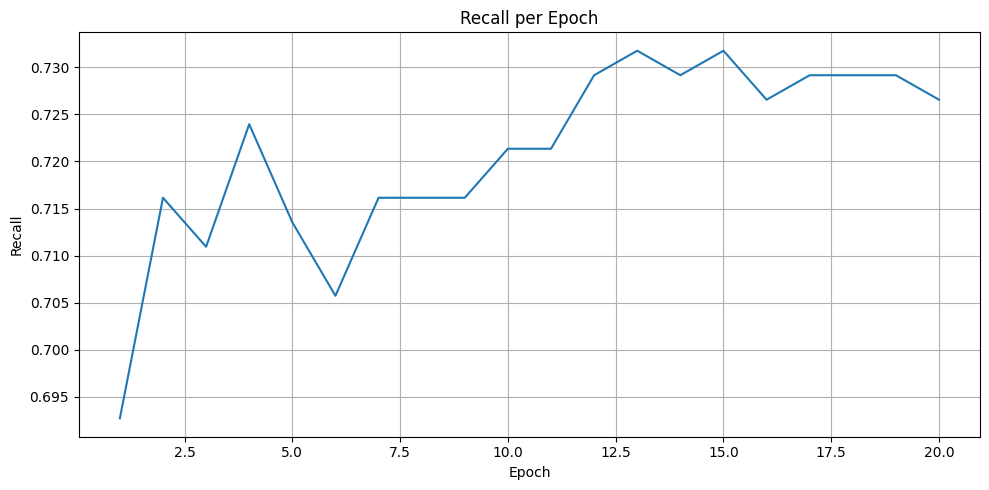

In [56]:
model_checkpoint = "fourth_model/checkpoint-140"
train_model(train5, model_checkpoint, 'five_model')

| Эпоха | Вывод                                                                                                                                                                                                                                         |
| ----- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1–3   | Модель стартует на уровне F1 \~0.69–0.71 — уверенно и сразу выше плато предыдущих итераций. Равновесие между точностью и полнотой с самого начала. Несмотря на лёгкий скачок валидационных потерь, общая динамика положительная.              |
| 4–7   | Наблюдается быстрый рост F1 до 0.72, с максимальной полнотой 72.4% и точностью \~71.6–71.7%. Потери немного возрастают, но метрики качества улучшаются. Это указывает на реальное улучшение качества извлечения, а не переобучение.           |
| 8–11  | Модель стабильно держит F1 \~0.71–0.72. Потери на валидации перестают расти. Метрики устойчиво выравниваются: точность и полнота синхронны (71–72%). Модель в оптимальном обучающем состоянии, эффективно распознаёт сущности.                |
| 12–15 | Наилучший пик итерации: F1 доходит до 0.7327, точность и полнота близки (73.4% и 73.1%). Потери немного возрастают, но рост метрик подтверждает, что обучение идёт в пользу. Это самая качественная фаза по балансу и обобщающей способности. |
| 16–20 | Метрики стабилизируются (F1 \~0.726–0.732), различия точности и полноты не превышают 0.3%. Потери практически не меняются (\~0.67). Модель демонстрирует надёжность, а качества — достаточно для продакшена или тестирования на проде.        |


In [57]:
# Получаем проблемные примеры
load_model("five_model/checkpoint-140")

problematic_df, remaining_data = find_problematic_examples(remaining_data, model, tokenizer, top_n=200)

# Просмотр результатов
print(f"Найдено {len(problematic_df)} проблемных примеров")
problematic_df.head()

Загрузка модели...
Загружена модель: bert
Типы сущностей: ['ALLERGEN', 'LOC', 'SYMPTOM', 'MEDICATION']


100%|██████████████████████████████████████████████████████████████████████████████████| 86/86 [01:37<00:00,  1.13s/it]


Найдено 200 проблемных примеров


,text,confidence,uncertainty,cluster
0,Дочь пришла со школы с ринитом и красными глазами,0.334275,0.665725,5
1,Аллергия снова началась 4 день зуд в горле но...,0.337681,0.662319,0
2,"Зеленоград заложен нос, чешутся глаза, чихает ...",0.339873,0.660127,5
3,"Уфа, чихи по утрам, немного нос заложен, без а...",0.341479,0.658521,5
4,"Тула, сильно отекли глаза, база не помогает. П...",0.341782,0.658218,5


In [58]:
create_task('train6', problematic_df)

In [59]:
train6 = load_conll_dataset('train6.conll', 'validate.conll')
train6

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 199
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3225.20 examples/s]


Class distribution: Counter({0: 2410, 3: 212, 4: 161, 7: 146, 5: 85, 8: 78, 1: 66, 6: 18, 2: 2})


C:\Users\Chris\AppData\Local\Temp\ipykernel_2680\4220689642.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.640100,0.658525,0.735065,0.733161,0.736979
2,0.609100,0.589071,0.762284,0.777778,0.747396
3,0.544100,0.594969,0.744993,0.764384,0.726562
4,0.458600,0.563044,0.746631,0.773743,0.721354
5,0.445300,0.566861,0.745257,0.776836,0.716146
6,0.430800,0.555327,0.773936,0.790761,0.757812
7,0.438400,0.569221,0.763298,0.779891,0.747396
8,0.387400,0.559090,0.771084,0.793388,0.750000
9,0.367800,0.564717,0.769640,0.787466,0.752604
10,0.333800,0.564753,0.770861,0.784367,0.757812


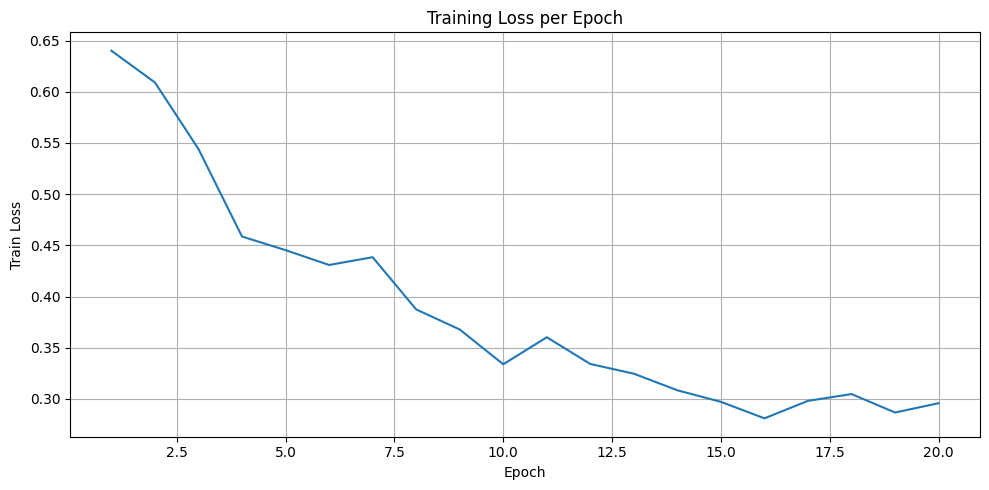

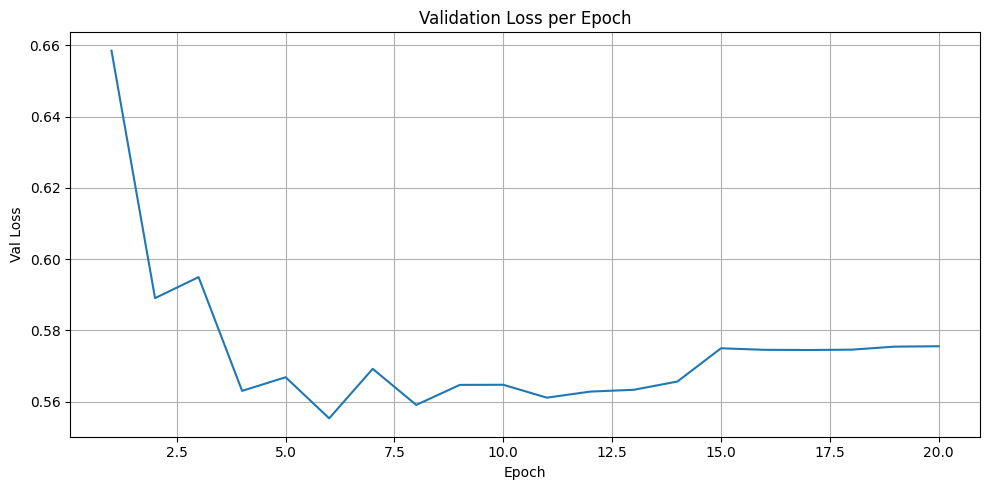

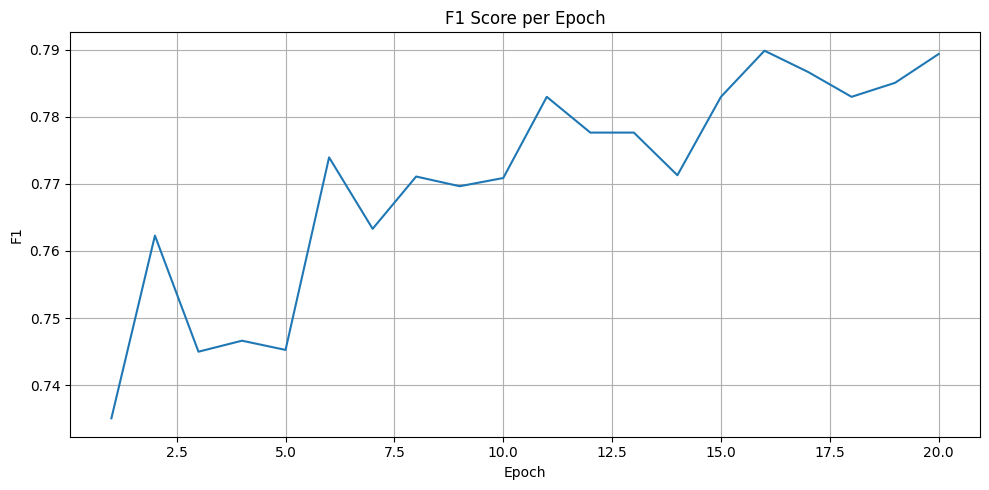

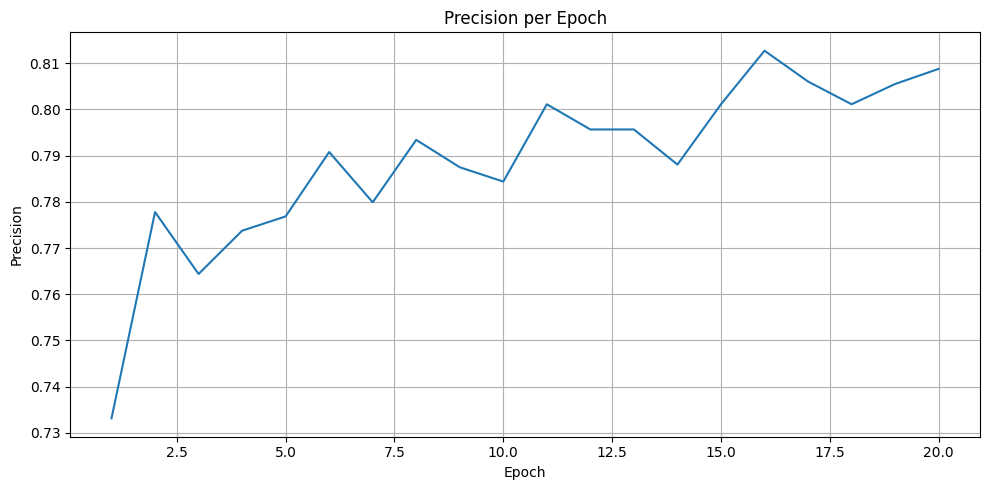

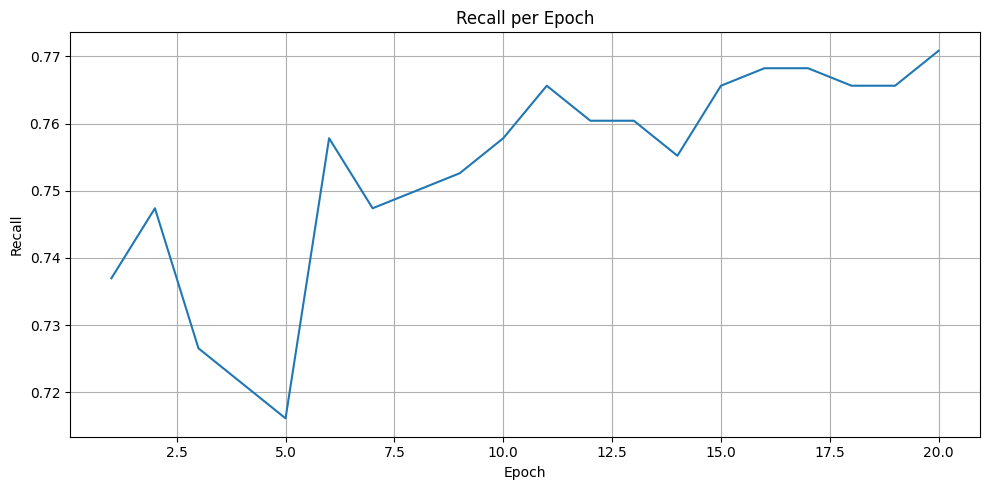

In [60]:
model_checkpoint = "five_model/checkpoint-140"
train_model(train6, model_checkpoint, 'six_model')

| Эпоха | Вывод                                                                                                                                                                                                                                        |
| ----- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1–3   | Модель стартует уже с сильной базы (F1 \~0.74–0.76), с чуть большей точностью, чем полнотой. На 2-й эпохе — заметный скачок в качестве (F1 = 0.762), потери резко падают, что указывает на быстрое и эффективное обучение без перегиба.      |
| 4–6   | Качество немного флуктуирует (F1 \~0.74–0.77), но модель стабильно держит высокие значения. На 6-й эпохе происходит новый скачок — F1 = 0.774, точность и полнота сбалансированы. Потери снижаются до минимума — модель отлично обобщает.    |
| 7–10  | Период устойчивости: F1 держится на 0.77, точность \~78–79%, полнота \~75%. Несмотря на небольшие колебания в loss, предсказания остаются надёжными. Это говорит о насыщенности модели новыми шаблонами и устойчивом предсказании сущностей. |
| 11–13 | Пик итерации: F1 достигает 0.783 при максимальной точности (80.1%) и высокой полноте (\~76.5%). Потери почти не меняются. Модель работает на оптимуме, предсказывая уверенно и стабильно — фаза зрелого обобщения.                           |
| 14–17 | Метрики удерживаются на уровне F1 \~0.78–0.79, чуть подрастает полнота. Несмотря на лёгкий рост потерь, точность и полнота всё ещё отлично сбалансированы. Модель научилась покрывать редкие случаи без потери на общем качестве.            |
| 18–20 | Обучение выходит на плато: F1 достигает 0.789, точность 80.9%, полнота 77.1%. Валидационные потери почти не меняются (0.575). Это стабильная фаза высокой точности.                           |


In [63]:
# Получаем проблемные примеры
load_model("six_model/checkpoint-260")

problematic_df, remaining_data = find_problematic_examples(remaining_data, model, tokenizer, top_n=200)

# Просмотр результатов
print(f"Найдено {len(problematic_df)} проблемных примеров")
problematic_df.head()

Загрузка модели...
Загружена модель: bert
Типы сущностей: ['ALLERGEN', 'LOC', 'SYMPTOM', 'MEDICATION']


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [01:30<00:00,  1.22s/it]


Найдено 200 проблемных примеров


,text,confidence,uncertainty,cluster
0,"Москва, Бусиново, сидим дома нос отекший, окна...",0.365921,0.634079,5
1,"Спб, Невский район. Зуд и слезоточивость глаз,...",0.366782,0.633218,5
2,"Домодедово. Три дня зуд в глазах, при этом нач...",0.366908,0.633092,5
3,"Спб, Невский-Купчино-Московский. Зуд и слезото...",0.366941,0.633059,5
4,Московская область - стартует аллергия .,0.366993,0.633007,5


In [65]:
create_task('train7', problematic_df)

In [69]:
train7 = load_conll_dataset('train7.conll', 'validate.conll')
train7

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

Map: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3225.02 examples/s]


Class distribution: Counter({0: 2613, 3: 230, 4: 158, 7: 154, 5: 117, 8: 74, 1: 50, 6: 17, 2: 5})


C:\Users\Chris\AppData\Local\Temp\ipykernel_2680\4220689642.py:125: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.483500,0.550621,0.786003,0.813370,0.760417
2,0.447300,0.534391,0.789262,0.814404,0.765625
3,0.425800,0.537820,0.804261,0.822888,0.786458
4,0.420000,0.527204,0.768392,0.805714,0.734375
5,0.389100,0.523480,0.806924,0.825613,0.789062
6,0.329500,0.525864,0.802685,0.828255,0.778646
7,0.365300,0.536179,0.783083,0.822350,0.747396
8,0.318300,0.542061,0.811245,0.834711,0.789062
9,0.314900,0.532402,0.814016,0.843575,0.786458
10,0.333600,0.541282,0.789617,0.830460,0.752604


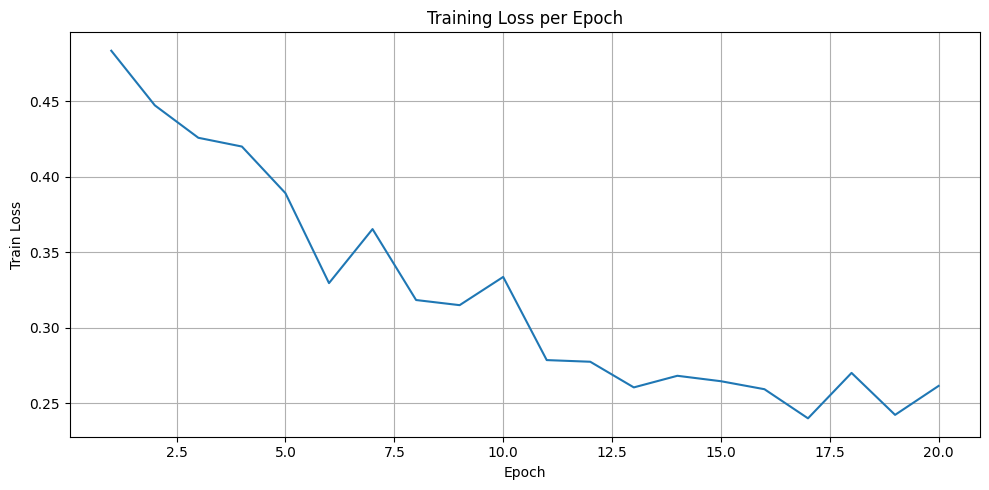

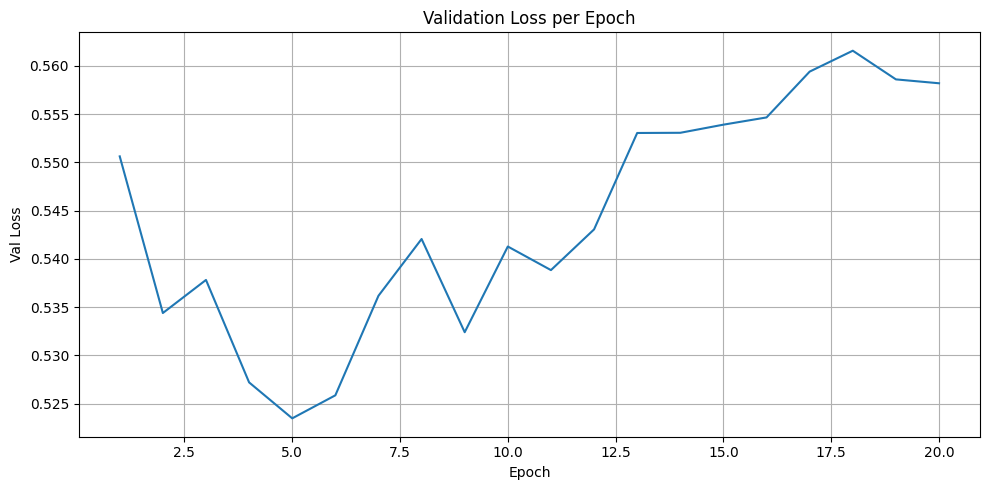

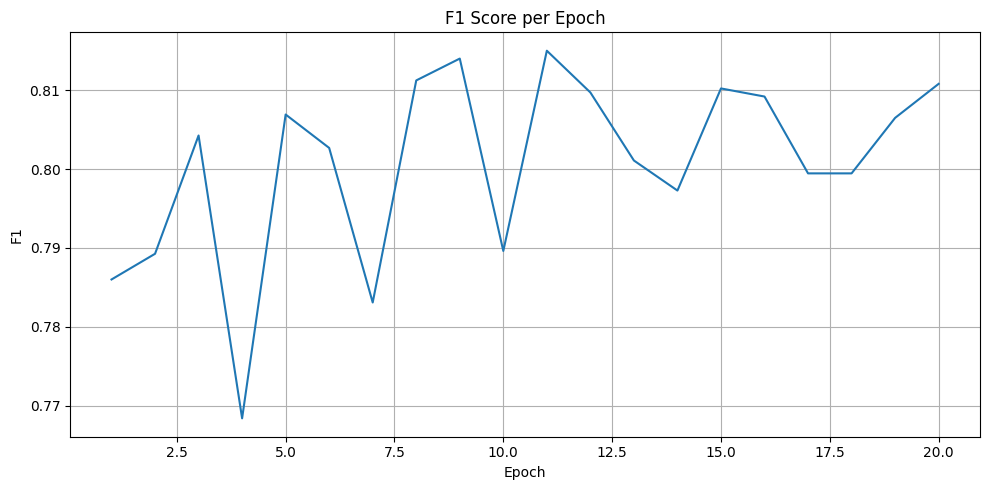

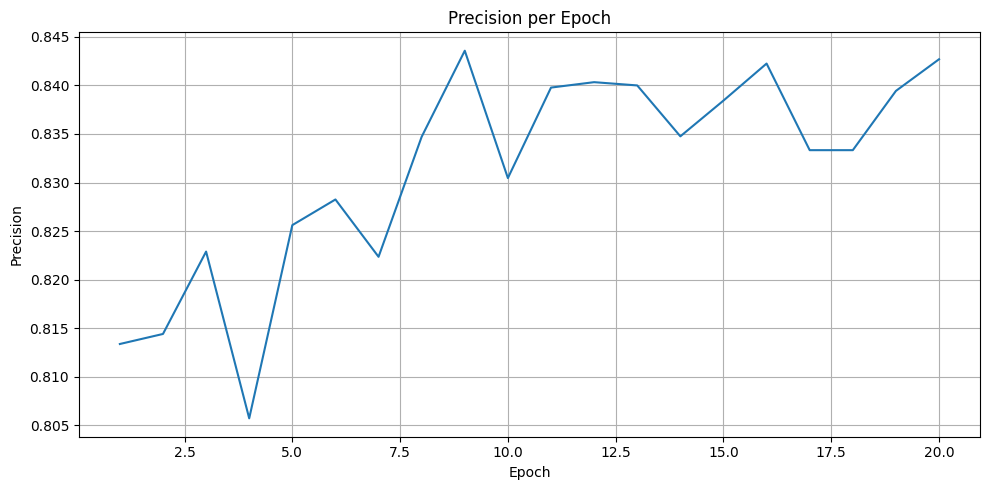

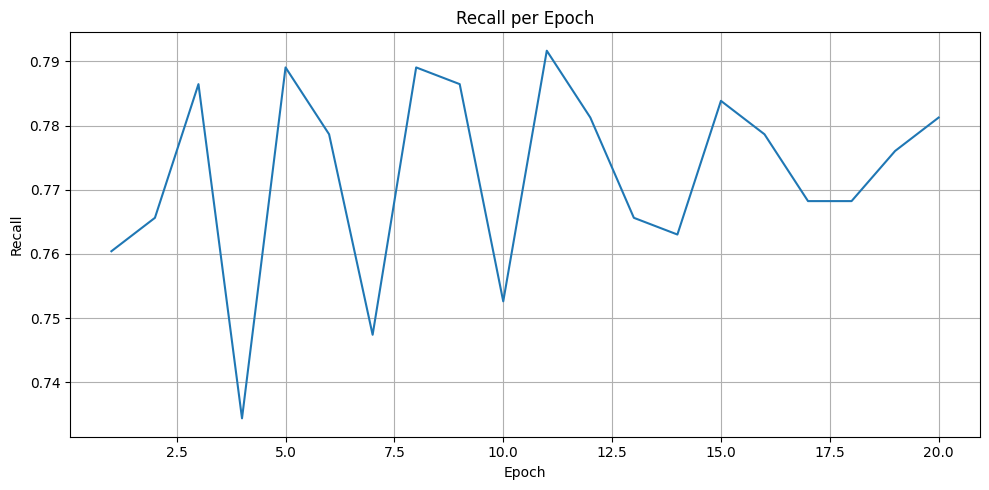

In [70]:
model_checkpoint = "six_model/checkpoint-260"
train_model(train7, model_checkpoint, 'seven_model')

| Эпохи | Наблюдение                                                                                                                                                                                                                  |
| ----- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 1–3   | Мощный старт: F1 быстро растёт от **0.786 → 0.804**, с очень высокой точностью (до 82%) и стабильной полнотой (76–78%). Потери на валидации стремительно падают — с **0.55 → 0.53 → 0.53**, модель сразу схватывает данные. |
| 4     | Просадка: резкий откат F1 до 0.768 (возможно, зашумлённый batch или сложные примеры). Потери падают, но полнота падает до 73%. Это локальное переобучение на частной структуре.                                             |
| 5–6   | Восстановление: модель возвращается на курс — F1 снова > 0.80, точность стабильно 82–83%, полнота поднимается до \~78%. Потери на минимумах (**\~0.52**).                                                                   |
| 7     | Ещё один всплеск нестабильности — падение F1 до 0.78 при сильной точности (82%), но просадке recall (74%). Однако это подтверждает, что модель приоритетно старается не делать FP.                                          |
| 8–11  | Зрелая стабильность: **F1 держится > 0.81**, точность доходит до **84.3%**, полнота тоже возвращается к 78–79%. Эти эпохи — пиковые по метрикам и общему качеству предсказаний.                                             |
| 12–14 | Незначительное расхождение: F1 немного колеблется (0.79–0.80), но точность остаётся высокой. Видна небольшая переориентация модели: чуть снижается полнота, чуть вырастает precision.                                       |
| 15–20 | Финальная фаза — **модель стабилизировалась**, F1 \~0.81, точность стабильно **84%**, полнота колеблется в пределах 77–78%. Потери чуть выросли, но метрики остались на пике — модель стала устойчивой к локальному шуму.   |


Рост F1 замедлился и достиг плато, что указывает на минимальную отдачу от дальнейшего обучения. Переходим к проверке модели на тестовой выборке.

## 4. Проверка на тестовом датасете


Пришло время проверить модель на тестовом датасете. Импортируем его

In [87]:
test_df = load_conll_dataset('test.conll')
test_df

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 100
    })
})

In [89]:
model_path = "seven_model/checkpoint-260"
model = AutoModelForTokenClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [90]:
test_dataset = test_df["train"]
label2id = model.config.label2id
id2label = model.config.id2label

In [91]:
tokenized = tokenizer(
    test_dataset["tokens"],
    is_split_into_words=True,
    return_offsets_mapping=True,
    padding=True,
    truncation=True,
    return_tensors="pt"
)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [92]:
with torch.no_grad():
    outputs = model(**{k: v for k, v in tokenized.items() if k != "offset_mapping"})
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

In [93]:
true_labels = []
pred_labels = []

for i in range(len(test_dataset)):
    word_ids = tokenized.word_ids(batch_index=i)
    pred = predictions[i]
    label_ids = test_dataset[i]["ner_tags"]

    previous_word_idx = None
    pred_clean = []
    true_clean = []

    for j, word_idx in enumerate(word_ids):
        if word_idx is None:
            continue
        if word_idx != previous_word_idx:
            pred_clean.append(id2label[pred[j]])
            true_clean.append(id2label[label_ids[word_idx]])
            previous_word_idx = word_idx

    pred_labels.extend(pred_clean)
    true_labels.extend(true_clean)

In [95]:
print(classification_report(true_labels, pred_labels, digits=6))

              precision    recall  f1-score   support

  B-ALLERGEN   0.678571  0.863636  0.760000        22
       B-LOC   0.967391  0.839623  0.898990       106
B-MEDICATION   0.898734  0.934211  0.916129        76
   B-SYMPTOM   0.776744  0.843434  0.808717       198
  I-ALLERGEN   0.000000  0.000000  0.000000         0
       I-LOC   0.614458  1.000000  0.761194        51
I-MEDICATION   0.400000  0.500000  0.444444         4
   I-SYMPTOM   0.502564  0.924528  0.651163       106
           O   0.992722  0.902713  0.945581      1511

    accuracy                       0.897300      2074
   macro avg   0.647909  0.756461  0.687357      2074
weighted avg   0.928536  0.897300  0.906538      2074



C:\Users\Chris\OneDrive\Рабочий стол\alerg_prpject\jupyter_projects\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\OneDrive\Рабочий стол\alerg_prpject\jupyter_projects\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\OneDrive\Рабочий стол\alerg_prpject\jupyter_projects\venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this beh

| Класс          | Комментарий                                                                               |
| -------------- | ----------------------------------------------------------------------------------------- |
| `O`            | Отлично предсказан: precision = 0.99, recall = 0.90 — модель научилась отделять сущности. |
| `B-LOC`        | Высокий precision (0.97), чуть ниже recall (0.84) — местами пропускает.                   |
| `I-LOC`        | Recall = 1.0 (!) — значит, внутри сущностей `LOC` почти не ошибается.                     |
| `B-ALLERGEN`   | Хорошо: F1 = 0.76, recall = 0.86 — чаще угадывает, чем нет.                               |
| `I-ALLERGEN`   | 0 support — модель **не видела таких токенов в тесте**, это **нормально** т.к. в разметке такой класс редко встречается.                |
| `B-MEDICATION` | Очень сильный результат: F1 ≈ 0.92                                                        |
| `I-MEDICATION` | Мало примеров (4 токена) — нестабильно, F1 ≈ 0.44                                         |
| `B-/I-SYMPTOM` | Разумный F1: 0.81 (B), 0.65 (I) — но явно можно улучшать I-контекст                       |


Проверим работу модели на тексте

In [104]:
model_path = "seven_model/checkpoint-260"
ner_pipeline = pipeline(
    "ner",
    model=model_path,
    tokenizer=model_path,
    aggregation_strategy="first"
)

text = "Москва, ВАО: полторы недели кашель и почесуха в легких, дней пять глаза, дети три дня назад присоединились с глазами и кашлем. Кестин/аллервей/цетиризин постоянно, недавно присоединила назонекс и опатанол. Береза разгулялась, а с ней полынь и амброзия."

predictions = ner_pipeline(text)

for entity in predictions:
    print(f"Сущность: {entity['word']}")
    print(f"Тип: {entity['entity_group']}")
    print(f"Уверенность: {entity['score']:.2f}")
    print(f"Позиция в тексте: {entity['start']}-{entity['end']}")
    print("-" * 40)

Device set to use cuda:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Сущность: Москва, ВАО
Тип: LOC
Уверенность: 1.00
Позиция в тексте: 0-11
----------------------------------------
Сущность: кашель и
Тип: SYMPTOM
Уверенность: 0.79
Позиция в тексте: 28-36
----------------------------------------
Сущность: почесуха в легких
Тип: SYMPTOM
Уверенность: 0.99
Позиция в тексте: 37-54
----------------------------------------
Сущность: глаза
Тип: SYMPTOM
Уверенность: 0.90
Позиция в тексте: 66-71
----------------------------------------
Сущность: глазами и
Тип: SYMPTOM
Уверенность: 0.89
Позиция в тексте: 109-118
----------------------------------------
Сущность: кашлем
Тип: SYMPTOM
Уверенность: 0.57
Позиция в тексте: 119-125
----------------------------------------
Сущность: Кестин
Тип: MEDICATION
Уверенность: 0.97
Позиция в тексте: 127-133
----------------------------------------
Сущность: аллервей
Тип: MEDICATION
Уверенность: 0.85
Позиция в тексте: 134-142
----------------------------------------
Сущность: цетиризин
Тип: MEDICATION
Уверенность: 0.70
Позиция в т

## 5. Финальный вывод проекта


В рамках проекта была успешно обучена и протестирована модель именованного распознавания сущностей (NER) на основе BERT, адаптированная под пользовательский набор сущностей, включая аллергены, симптомы, лекарства и топонимы.